## Отчет анализа стоимости ювелирных изделий у МЮЗ

### 1. Парсинг 
 С сайта https://miuz.ru были спарсены данные ювелирных издели предлагаемых на интернет магазине с фильтром - кольца - основной камнень бриллиант
https://miuz.ru/catalog/rings/filter/stones_main-is-brilliant/ 
Процесс парсинга, реализован в файле ParsingMiuz.ipynb, процесс очистки и расчет прейскуратной стоимости
бриллиантов в файле for_parsing_func.ipynb

Всего колец с фильтром бриллиант на сайте более 5000 изделий, часть данных было отброшено по причинам:
- если изделие содержало другие камни или жемчуг кроме бриллианта
- изделие не могло правильно считаться парсером
- характеристики бриллиантов содержало ошибки
- были использованы фантазийные по цвету бриллианты (возможно синтетика)

В результате получен датасет с ювелирными изделиями со следующими данными (параметрами):
- Наименование(кольца только с бриллиантами  в количестве 1273 изделия), 
- Артикул,
- Ссылка на карточку с изделием (кликабельная ссылка)
- Стоимость изделия в рублях с учетом скидки (цены от 6труб до 1млн руб, на общую сумму 103 млн рублей, средняя стоимость 81т руб),
- масса изделия в граммах (от 0,86 до 22 грамма, общая масса 3172грамма средний вес 2,96 грамма),
- проба золота (585 проба - 1138 шт, 750 - 110шт, 375 - 26 шт),
- штук бриллиантов (всего 36724 штук, в среднем на изделие 29 бриллиантов)
- карат бриллиантов (всего 444 карат средняя масса камня 0,012 карат)
- прейскурантная стоимость бриллиантов в долларах (всего 206 тыс долларов, со средней прейскурантной стоимостью 464 доллара за карат)
Датасет приведен в файле _брилл_суммированы_mius161121_0-3178.xlsx

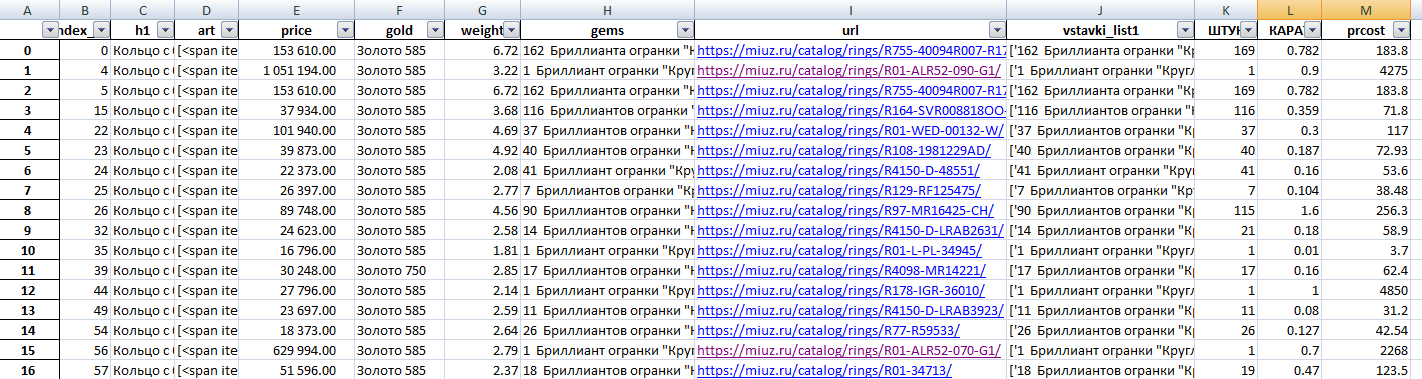

ЗАМЕЧАНИЯ: Данные были спарсены 16.11.2021, на 03.12.2021 были обнаружены изменения по цене! Дополнительные скидки и наценки !!! Необходимо в будущем повторить парсинг для изучения этого вопроса
- в изделии https://miuz.ru/catalog/rings/R01-ALR52-090-G1/ было 1 051 194 руб на сегодня 875 995 руб (при базовой цене 1 751 990 руб) 
- в изделии https://miuz.ru/catalog/rings/R4211-RG1059WDI1/  было 239 400 руб на сегодня 199 500 руб (при базовой цене 399 000 руб)
- в изделии https://miuz.ru/catalog/rings/R129-RF125059/  было 44 397 руб на сегодня 75 245 руб (при базовой цене  150 490 руб) 
_брилл_суммированы_mius161121_0-3178

### 2. Анализ датасета МЮЗ, визуализация, определение коэфициентов
#### 2.1 Считывание данных с файла
Для этого устанавливаем необходимые модули.
 - загружаем данные с файла 
 - откыдываем изделия дороже 500т руб, 
 - оставляем изделия пробы 585,
 - отбрасываем изделия с бриллиантами по прейскуранту свыше 3000 долларов
 - оставлены поля price : цена изделя, weight: масса изделия в граммах, prcost: прейскурант в долларах

In [347]:
import numpy as np
import pandas as pd
import re
import os
import matplotlib.pyplot as plt
#%matplotlib inline
%matplotlib notebook
filenamemiuz = 'jewels/miuz/_брилл_суммированы_mius161121_0-3178.xlsx'
raw = pd.read_excel(filenamemiuz,sheet_name=0)
data = raw.loc[(raw.gold.str.contains('585') ),['price','weight','prcost']].loc[(raw.price<500000),:].loc[(raw.prcost<3000),:]
data.head()

,price,weight,prcost
0,153610,6.72,183.80
2,153610,6.72,183.80
3,37934,3.68,71.80
4,101940,4.69,117.00
5,39873,4.92,72.93


Получен датасет с 1124 данными общая масса изделий 3034 грамма на сумму 60 млн рублей с прейскурантной стоимостью 123 тыс долл 

In [348]:
#сумма датасета
data.describe()

,price,weight,prcost
count,1124.00,1124.00,1124.00
mean,54141.25,2.70,100.97
std,58972.09,1.13,168.09
min,8697.00,0.96,1.60
25%,22373.00,1.92,20.54
50%,34120.50,2.42,49.27
75%,61270.50,3.19,103.50
max,478194.00,8.30,1680.00


In [349]:
data.sum()

price    60854763.00
weight       3034.32
prcost     113494.67
dtype: float64

#### 2.2 Визуализиация данных
Построим облако точек в трехмерной плоскости
- х вес золота в граммах
- y стоимость прейскурантная бриллиантов
- z стоимость изделия в тысячах рублей

Если покрутить график, то видно что точки стремятся к плоскости



<IPython.core.display.Javascript object>


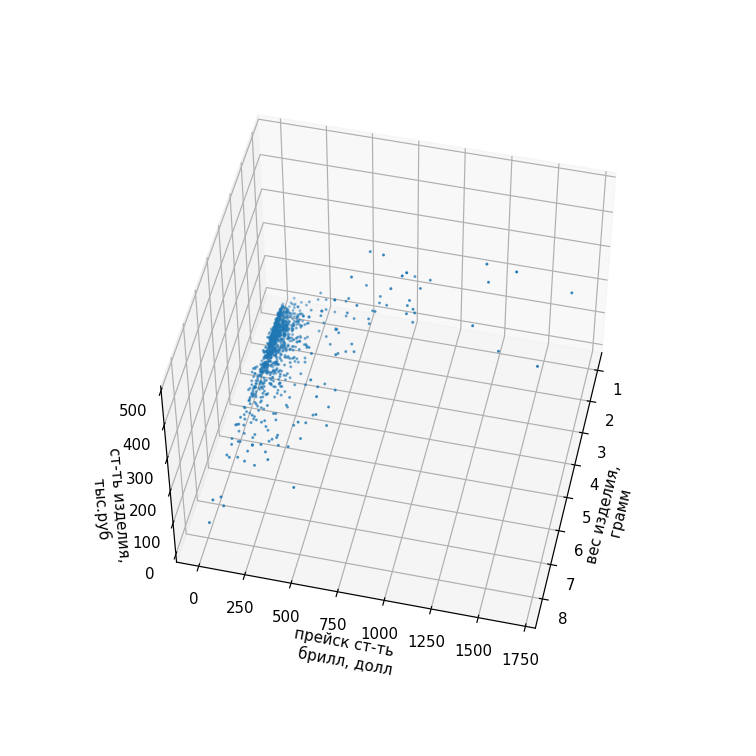

In [350]:
#
fig = plt.figure(figsize=(7,7))
ax = fig.gca(projection = "3d")
ax.scatter3D(data.weight,data.prcost,data.price/1000,s=1,c='#1f77b4')
ax.set_xlabel('вес изделия, \n грамм')
ax.set_ylabel('прейск ст-ть \n брилл, долл')
ax.set_zlabel('ст-ть изделия,\n тыс.руб')
ax.view_init(45,0)
#todo 3 projection need

#### 2.3 Подготовка данных для определения коэффициентов  

Для того чтобы полученные коэффициенты имели интерпретируемый смысл, предлагается прейскурантную стоимость бриллиантов перевести в рубли, граммы золота перевести в биржевую стоимость золота, данного веса изделия в рублях. 

In [351]:
#Курс доллара и биржевая цена золота на 03-12-2021
dollar_rate = 73.66
gold_rate = 4191.05

In [352]:
data['prcost_rub'] = data.prcost*dollar_rate
data['gold_rub'] = data.weight*0.585*gold_rate

In [353]:
pd.options.display.float_format ="{:.2f}".format
data.head()

,price,weight,prcost,prcost_rub,gold_rub
0,153610,6.72,183.80,13538.71,16475.86
2,153610,6.72,183.80,13538.71,16475.86
3,37934,3.68,71.80,5288.79,9022.49
4,101940,4.69,117.00,8618.22,11498.77
5,39873,4.92,72.93,5372.02,12062.68


<IPython.core.display.Javascript object>


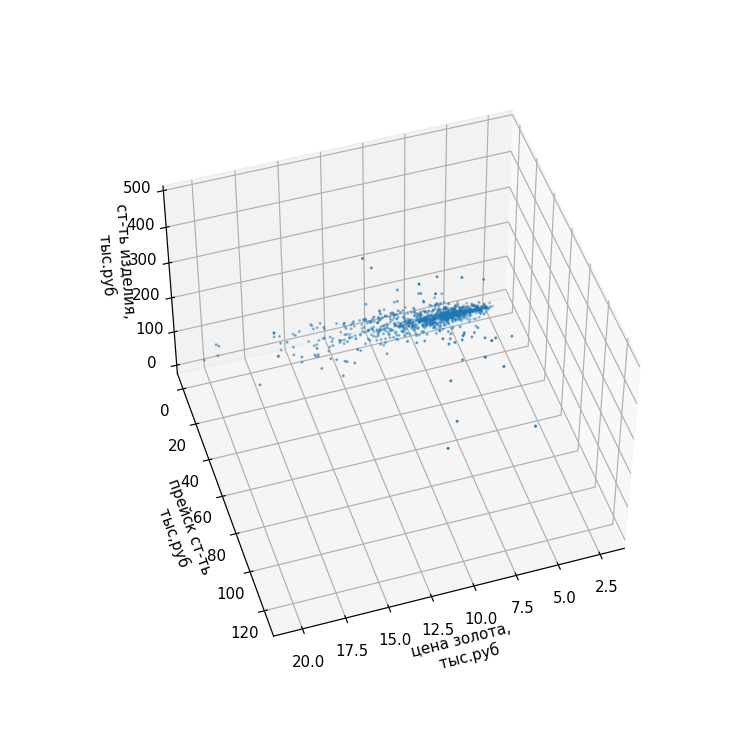

In [354]:
#новое графическое представление будеть иметь вид
fig2 = plt.figure(figsize=(7,7))
ax = plt.gca(projection = "3d")
ax.scatter3D(data.gold_rub/1000,data.prcost_rub/1000,data.price/1000,s=1,c='#1f77b4')
ax.set_xlabel('цена золота, \n тыс.руб')
ax.set_ylabel('прейск ст-ть \n тыс,руб')
ax.set_zlabel('ст-ть изделия,\n тыс.руб')
ax.view_init(45,0)

Цена ювелирного изделия в первом приближении формируется линейной зависимостью, если обозначить за Z - цену издели, X - масса золота, Y - прейскурнтная стоимость бриллианов то можно записть закономерностю вида:

$$ Z = f(X,Y) = НДС*СКИДКА*НАЦЕНКА*\\(ПРОБА*БИРЖЕВАЯСТОИМОСТ*НАЦЕНКАЗОЛОТА*СЛОЖНОСТЬ*X\\ 
+НАЦЕНКАПРЕЙСКУРАНТ*СЛОЖНОСТЬ*Y+НАЦЕНКАБЕЗДКДМ) $$
можно раскрыть скобки, перемножить множители и мы получим уравнение вида:
$$ Z = A*X+B*Y+C $$
линейное уравнение такого вида в трехмерной плоскости является плоскостью, поэтому необходимо усредненную плоскость и найти эти три коэффициента.

#### 2.4 Вычисление коэффициентов усредненой по облаку данных плоскости  

Для этого мы устанавливаем модуль отвечающий за расчеты линейной алгебры, и загружаем наши данные для расчета коэффициентов, и получаем коэффициенты



In [365]:
from sklearn import linear_model
#подготовка данных 
X_train = data.iloc[:,:].loc[:,['gold_rub','prcost_rub']].to_numpy()
Y_train = data.iloc[:,:].loc[:,'price'].to_numpy()
miuz.fit(X_train,Y_train)
A,B = miuz.coef_
C =  miuz.intercept_
A,B,C

(3.3006890651043186, 4.045575819492812, 2204.9906085763214)

In [367]:
#проверка
data['predict'] = miuz.predict(X_train)
data['bycoef'] = data.gold_rub*miuz.coef_[0] + data.prcost_rub*miuz.coef_[1]+miuz.intercept_
data['diff'] = data.predict-data.bycoef
data.head()

,price,weight,prcost,prcost_rub,gold_rub,predict,bycoef,diff
0,153610,6.72,183.80,13538.71,16475.86,111358.54,111358.54,0.00
2,153610,6.72,183.80,13538.71,16475.86,111358.54,111358.54,0.00
3,37934,3.68,71.80,5288.79,9022.49,53381.63,53381.63,-0.00
4,101940,4.69,117.00,8618.22,11498.77,75024.53,75024.53,0.00
5,39873,4.92,72.93,5372.02,12062.68,63753.08,63753.08,0.00


Усредненная по нашим данным плоскость и коэффициенты посчитаны модулем по методу наименьних квадратов, постороим на плоскость построенной плоскости для проверки

In [368]:
x_val = np.linspace(0,20000,10)# np.arange(0, 20000,5000)
y_val = np.linspace(0,130000,10)
xx,yy = np.meshgrid(x_val,y_val)

In [369]:
zz = A*xx + B*yy + C/1000

<IPython.core.display.Javascript object>


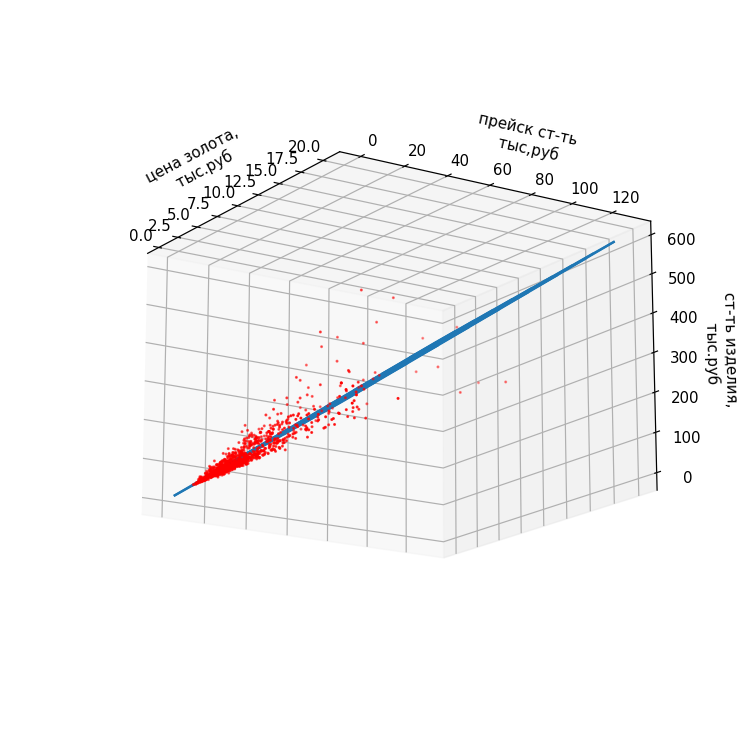

Text(0.5, 0, 'ст-ть изделия,\n тыс.руб')

In [372]:
fig = plt.figure(figsize=(7,7))
ax = fig.gca(projection='3d')
ax.plot_wireframe(xx/1000, yy/1000, zz/1000 )
ax.scatter3D(data.gold_rub/1000,data.prcost_rub/1000,data.price/1000,s=1,c='red')
#ax.scatter3D(data.gold_rub/1000,data.prcost_rub/1000,data.predict/1000,s=1,c='red')
#ax.scatter3D(data.gold_rub/1000,data.prcost_rub/1000,data.bycoef/1000,s=1,c='green')
ax.set_xlabel('цена золота, \n тыс.руб')
ax.set_ylabel('прейск ст-ть \n тыс,руб')
ax.set_zlabel('ст-ть изделия,\n тыс.руб')
#ax.plot_surface(xx/1000, yy/1000, zz/1000)